In [1]:
import IPython.display

from ppget.source import DataSource

A_DAY = 60 * 24
DAYS_OF_DATA = 90

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [2]:
from ppget.model import Model

WINDOW = 48
MODEL_TYPE = "cnn1d"

online_model = Model(name="test", model_type=MODEL_TYPE, window=WINDOW)
online_model.compile()
online_model.describe()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 4)             12        
                                                                 
 flatten (Flatten)           (None, 184)               0         
                                                                 
 dropout (Dropout)           (None, 184)               0         
                                                                 
 dense (Dense)               (None, 13)                2405      
                                                                 
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________


2022-07-12 17:48:23.468658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# collect R2 results for Online trained models
score_online = []
# collect R2 results for Batch learning
score_batch = []
score_baseline = []
# collect P Values
p_value_batch = []
p_value_online = []
p_value_cross = []

In [4]:
from sklearn.metrics import r2_score
from ppget.reports import report_results
import numpy as np
from statsmodels.stats.weightstats import ztest

BATCH_SIZE = 32
iteration = 0

# Iterate over 46 windows (roughly 4 years)
for frame in source:
    # window groups a measurements into a vector of size [sequence_length]
    window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

    # Data is normalized per window [not global!]
    X_train, y_train = window.train_data(True)
    X_test, y_test = window.test_data(True)
    # Get the last value of the input sequence (baseline = persistence model)
    p = list(map(lambda x: np.mean(x), y_test))
    baseline = X_test[:,-1,:]
    score_baseline.append(r2_score(p, baseline))
    # Always start batch model from scratch
    batch_model = Model(name="batch", model_type=MODEL_TYPE, window=WINDOW)
    batch_model.compile()

    online_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    batch_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE)

    online_predictions = online_model.predict(X_test)
    batch_predictions = batch_model.predict(X_test)
    # baseline = Model.baseline(X_test)

    score_online.append(report_results(y_test, online_predictions, render=False))
    score_batch.append(report_results(y_test, batch_predictions, render=False))
    # score_baseline.append(r2_score(y_test, baseline))
    b = list(map(lambda x: np.mean(x), baseline))
    o = list(map(lambda x: np.mean(x), online_predictions))
    bt = list(map(lambda x: np.mean(x), batch_predictions))
    _, p1 = ztest(x1=b, x2=bt, value=0)
    p_value_batch.append(p1)
    _, p2 = ztest(x1=b, x2=o, value=0)
    p_value_online.append(p2)
    _, p3 = ztest(x1=o, x2=bt, value=0)
    p_value_cross.append(p3)

    IPython.display.clear_output()

    if iteration == 46:
        break
    else:
        iteration += 1

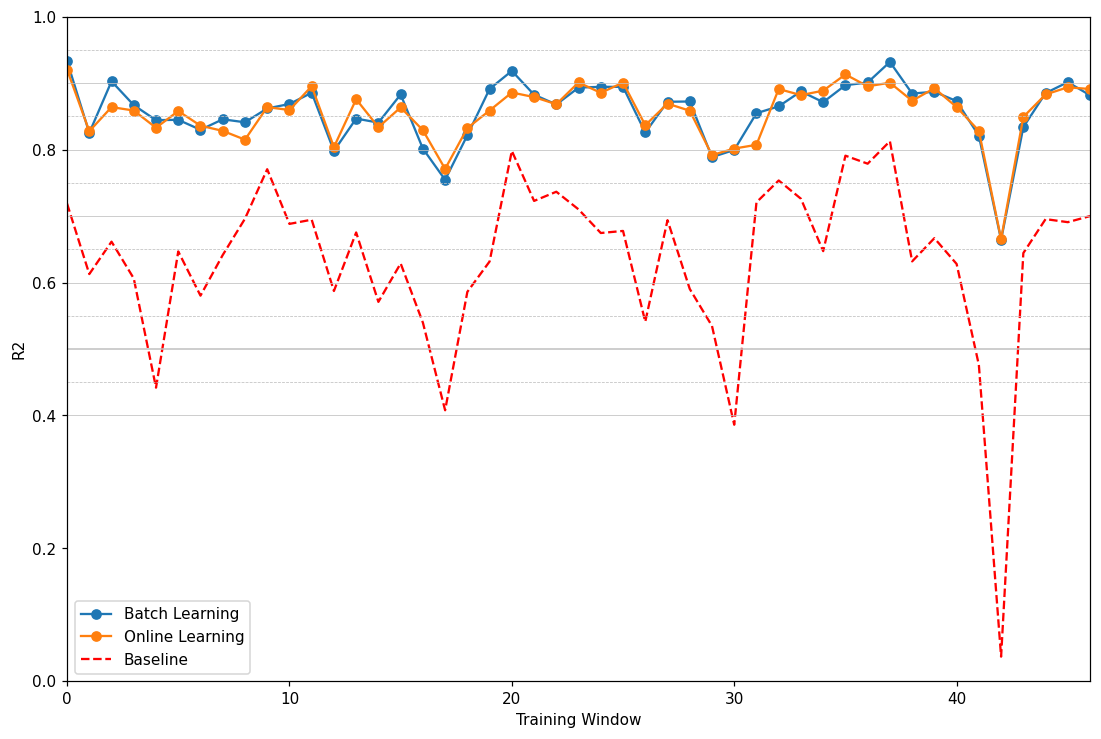

In [5]:
import matplotlib.pyplot as plt

def report_results(batch, online, base):
    plt.figure(figsize=(12, 8), dpi=110)
    plt.ylim([0, 1])
    plt.xlim([0, 46])
    plt.plot(batch, marker='o', label='Batch Learning')
    plt.plot(online, marker='o', label='Online Learning')
    plt.plot(base, color="r", linestyle="dashed", label='Baseline')
    plt.ylabel("R2")
    plt.xlabel("Training Window")
    plt.legend()
    plt.axhline(0.4, color='silver', linewidth=0.5)
    plt.axhline(0.45, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.5, color='silver', linewidth=1)
    plt.axhline(0.55, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.6, color='silver', linewidth=0.5)
    plt.axhline(0.65, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.7, color='silver', linewidth=0.5)
    plt.axhline(0.75, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.8, color='silver', linewidth=0.5)
    plt.axhline(0.85, color='silver', linestyle="dashed", linewidth=0.5)
    plt.axhline(0.9, color='silver', linewidth=0.5)
    plt.axhline(0.95, color='silver', linestyle="dashed", linewidth=0.5)
    plt.savefig(f"img/{MODEL_TYPE}_{WINDOW}.png")
    plt.show()

report_results(score_batch, score_online, score_baseline)

In [6]:
import statistics

mean_online = statistics.mean(score_online)
var_online = statistics.stdev(score_online) ** 2
mean_batch = statistics.mean(score_batch)
var_batch = statistics.stdev(score_batch) ** 2
mean_baseline = statistics.mean(score_baseline)

print(f"Online: mean({mean_online:.4f}), gain({mean_online - mean_baseline:.4f}), var({var_online:.4f}) | Batch: mean({mean_batch:.4f}), gain({mean_batch - mean_baseline:.4f}), var({var_batch:.4f})")

Online: mean(0.8560), gain(0.2208), var(0.0020) | Batch: mean(0.8583), gain(0.2232), var(0.0023)


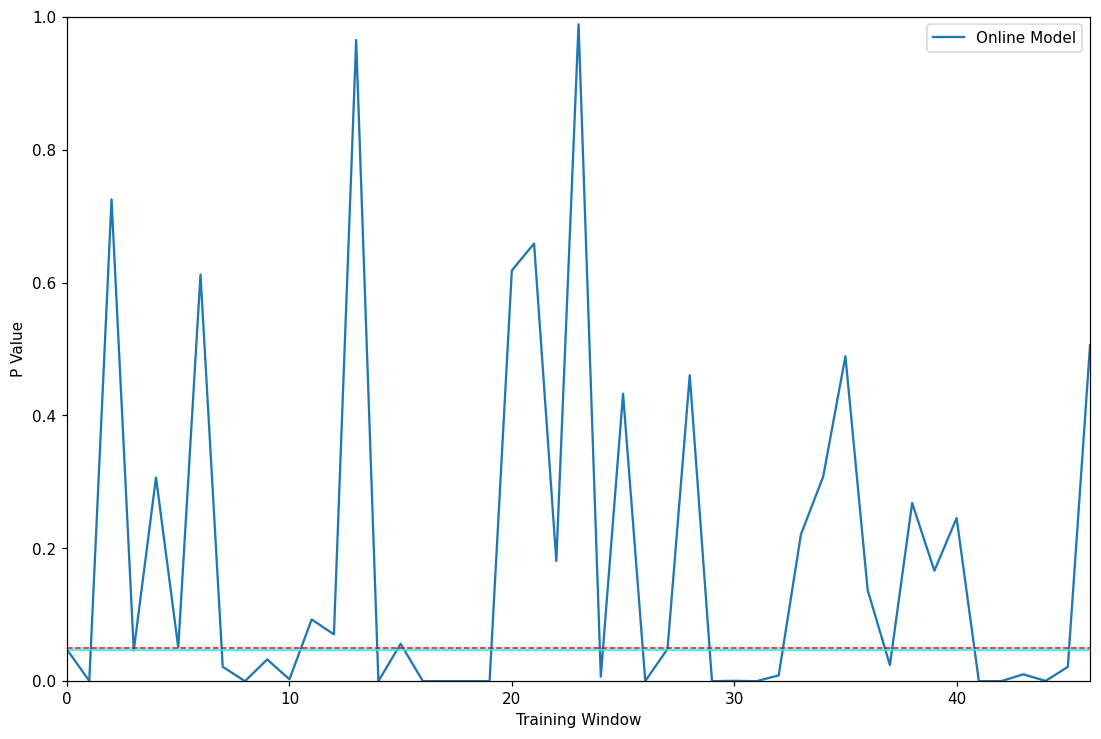

Online Model: Median P Value(0.0475), Below P Value(0.05): 25/47


In [7]:
def report_hypothesis_check(series, label):
    median_pvalue = np.median(series)
    plt.figure(figsize=(12, 8), dpi=110)
    plt.ylim([0, 1])
    plt.xlim([0, 46])
    plt.plot(series, label=label)
    plt.ylabel("P Value")
    plt.xlabel("Training Window")
    plt.legend()
    plt.axhline(0.05, color='red', linestyle='dashed', linewidth=1)
    plt.axhline(median_pvalue, color='cyan', linewidth=1)
    plt.savefig(f"img/p_value_{label}.png")
    plt.show()

    return median_pvalue

p_value = report_hypothesis_check(p_value_online, 'Online Model')
print(f"Online Model: Median P Value({p_value:.4f}), Below P Value(0.05): {len(list(filter(lambda x: x <= 0.05, p_value_online)))}/{len(p_value_online)}")

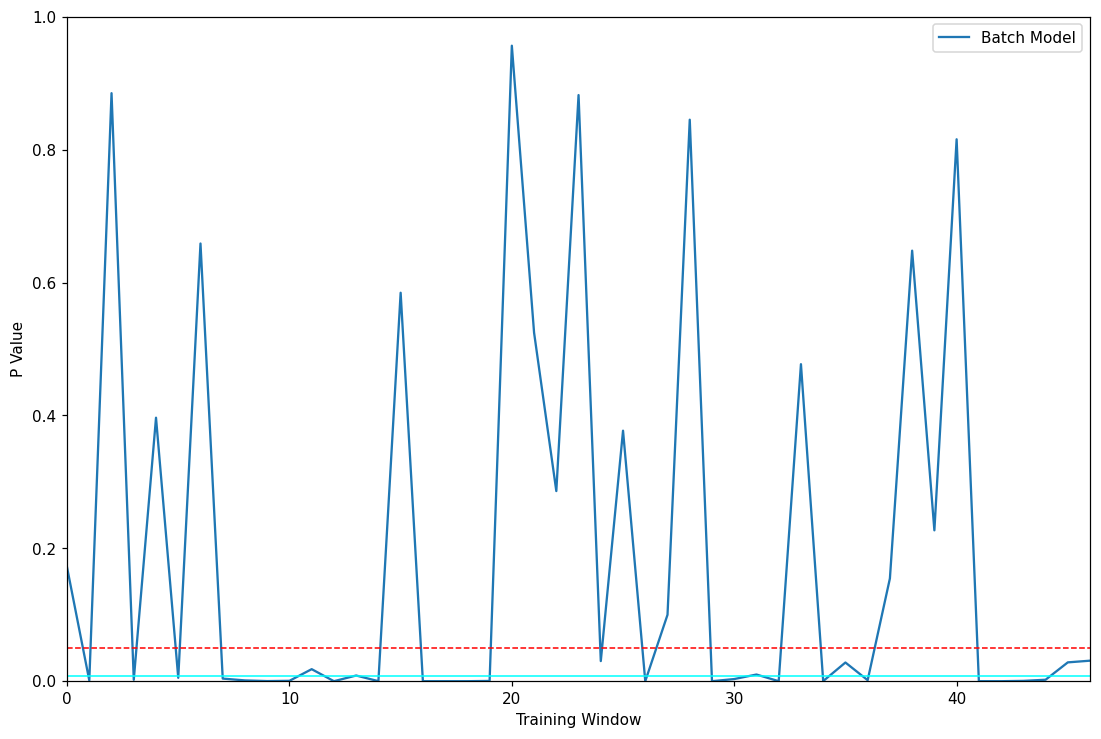

Batch Model: Median P Value(0.0085), Below P Value(0.05): 30/47


In [8]:
p_value = report_hypothesis_check(p_value_batch, 'Batch Model')
print(f"Batch Model: Median P Value({p_value:.4f}), Below P Value(0.05): {len(list(filter(lambda x: x <= 0.05, p_value_batch)))}/{len(p_value_batch)}")

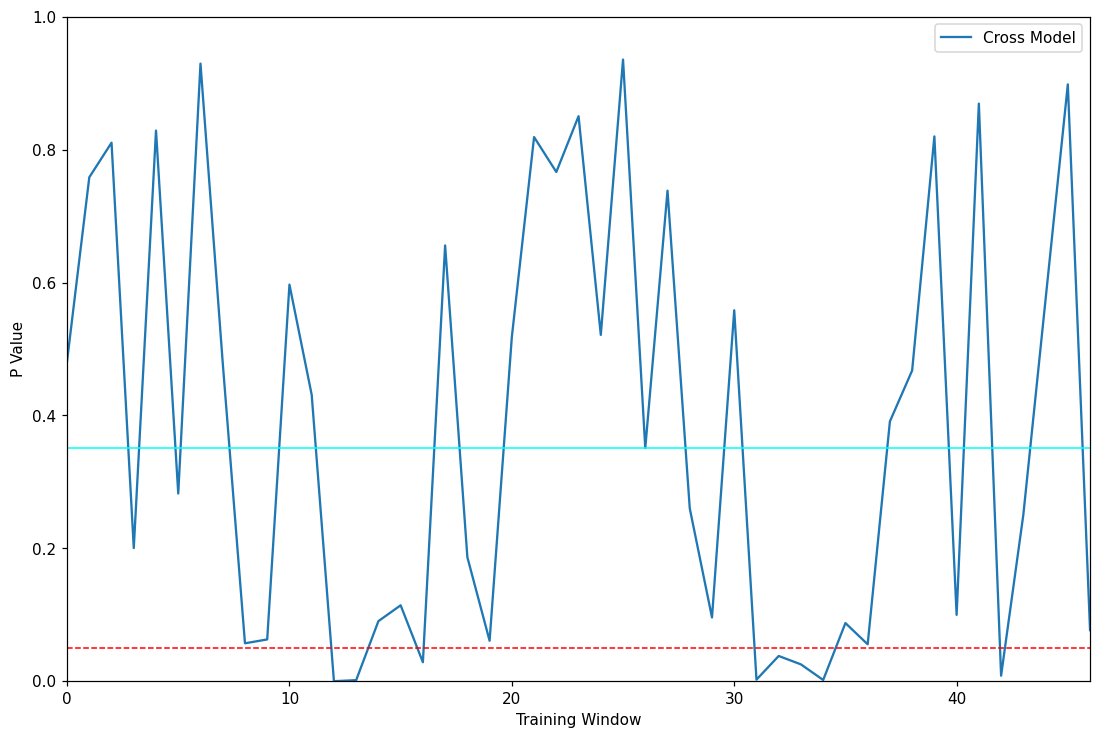

Cross Model: Median P Value(0.3508), Below P Value(0.05): 8/47


In [9]:
p_value = report_hypothesis_check(p_value_cross, 'Cross Model')
print(f"Cross Model: Median P Value({p_value:.4f}), Below P Value(0.05): {len(list(filter(lambda x: x <= 0.05, p_value_cross)))}/{len(p_value_cross)}")